In [114]:
import warnings

warnings.filterwarnings('ignore')

In [115]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent / 'src'))

from config import DATA_DIR

In [116]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [117]:
df=pd.read_csv(DATA_DIR/'diabetes_prediction_dataset.csv')
print(df.head().to_string(index=False))
print(df.tail().to_string(index=False))

gender  age  hypertension  heart_disease smoking_history   bmi  HbA1c_level  blood_glucose_level  diabetes
Female 80.0             0              1           never 25.19          6.6                  140         0
Female 54.0             0              0         No Info 27.32          6.6                   80         0
  Male 28.0             0              0           never 27.32          5.7                  158         0
Female 36.0             0              0         current 23.45          5.0                  155         0
  Male 76.0             1              1         current 20.14          4.8                  155         0
gender  age  hypertension  heart_disease smoking_history   bmi  HbA1c_level  blood_glucose_level  diabetes
Female 80.0             0              0         No Info 27.32          6.2                   90         0
Female  2.0             0              0         No Info 17.37          6.5                  100         0
  Male 66.0             0            

In [118]:
print(df.describe().to_string())

                 age  hypertension  heart_disease            bmi    HbA1c_level  blood_glucose_level       diabetes
count  100000.000000  100000.00000  100000.000000  100000.000000  100000.000000        100000.000000  100000.000000
mean       41.885856       0.07485       0.039420      27.320767       5.527507           138.058060       0.085000
std        22.516840       0.26315       0.194593       6.636783       1.070672            40.708136       0.278883
min         0.080000       0.00000       0.000000      10.010000       3.500000            80.000000       0.000000
25%        24.000000       0.00000       0.000000      23.630000       4.800000           100.000000       0.000000
50%        43.000000       0.00000       0.000000      27.320000       5.800000           140.000000       0.000000
75%        60.000000       0.00000       0.000000      29.580000       6.200000           159.000000       0.000000
max        80.000000       1.00000       1.000000      95.690000       9

In [119]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB
None


In [120]:
print(df['gender'].value_counts())

gender
Female    58552
Male      41430
Other        18
Name: count, dtype: int64


In [121]:
df = df[df['gender'] != 'Other'].reset_index(drop=True)

In [122]:
print(df['smoking_history'].value_counts())

smoking_history
No Info        35810
never          35092
former          9352
current         9286
not current     6439
ever            4003
Name: count, dtype: int64


In [123]:
print(df['diabetes'].value_counts())

diabetes
0    91482
1     8500
Name: count, dtype: int64


In [124]:
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

In [125]:
df.duplicated().sum()  
df.drop_duplicates(inplace=True) 

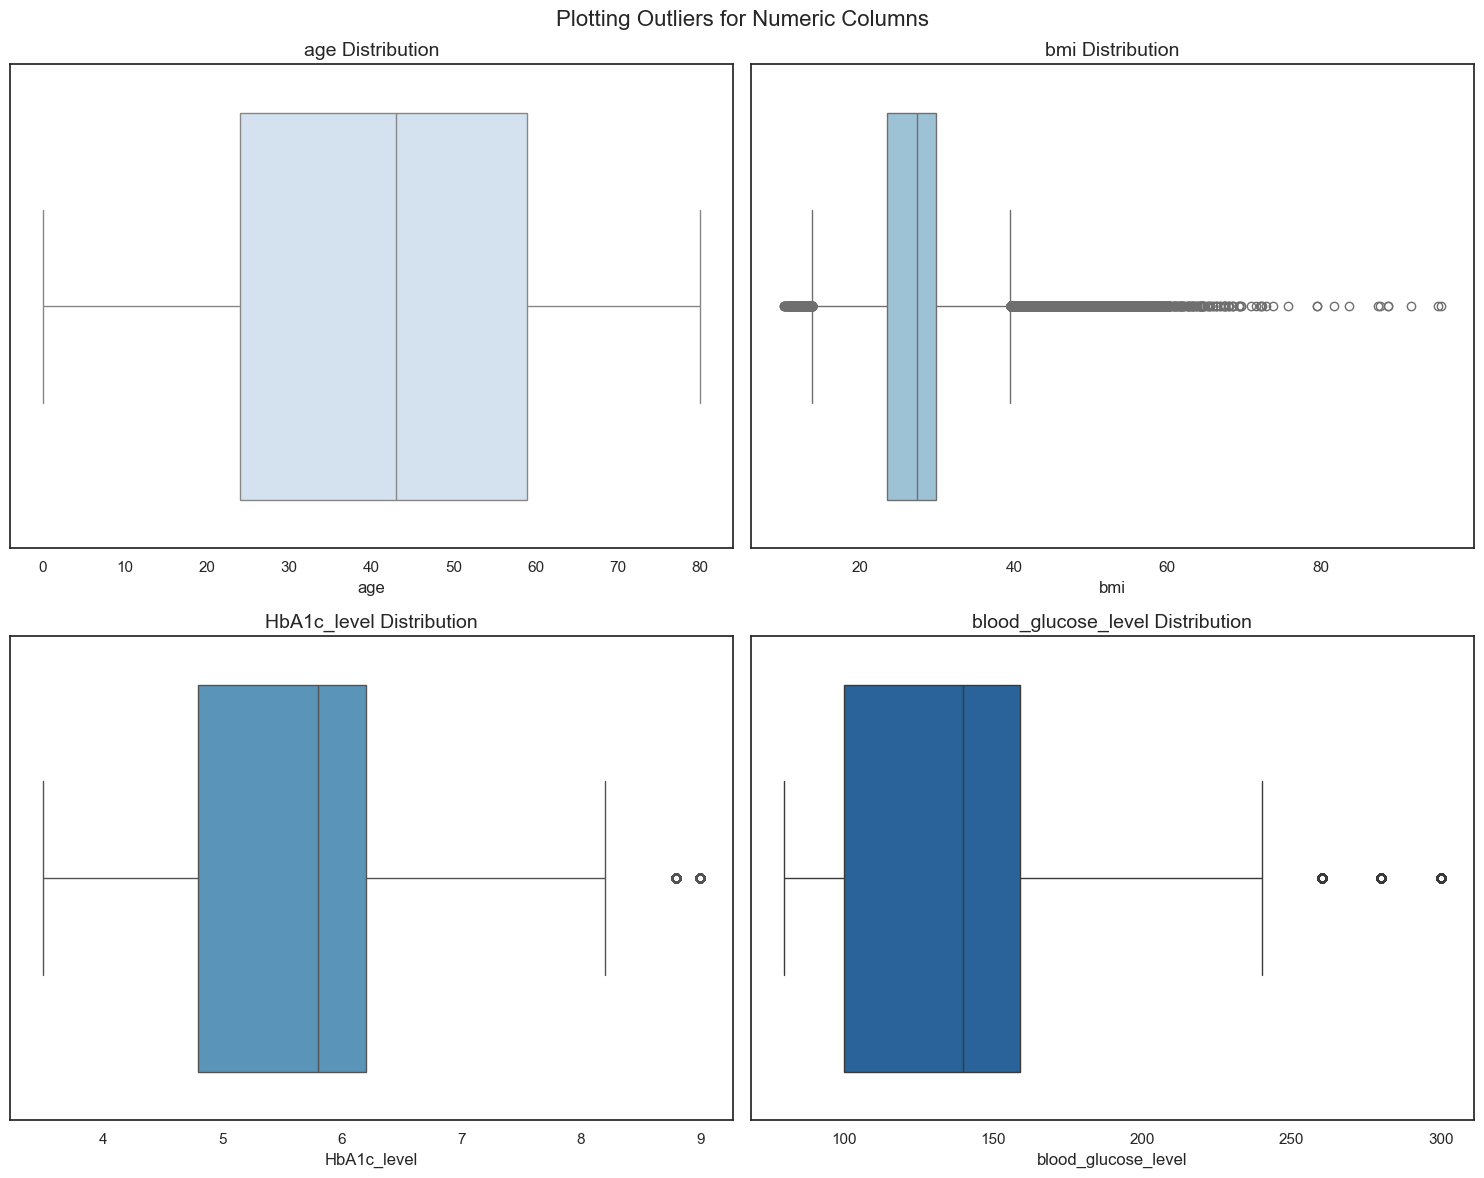

In [126]:
numeric_cols = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']

colors = sns.color_palette("Blues", n_colors=len(numeric_cols))  
plt.figure(figsize=(15, 12))
for count, i in enumerate(numeric_cols):
    plt.subplot(2, 2, count+1)
    sns.boxplot(data=df, x=i, color=colors[count])  
    plt.title(f'{i} Distribution', fontsize=14)  

plt.suptitle("Plotting Outliers for Numeric Columns", fontsize=16)
plt.tight_layout()
plt.show()


In [127]:
def get_whisker_bounds(df, column):
    fig, ax = plt.subplots()
    box = ax.boxplot(df[column].dropna(), vert=False)
    plt.close(fig)

    whiskers = [line.get_xdata()[1] for line in box['whiskers']]
    return whiskers[0], whiskers[1]

def remove_outliers_using_whiskers(df):
    df_clean = df.copy()
    outliers = {}

    for col in df.select_dtypes(include=[np.number]).columns:
        if col in ['bmi', 'blood_glucose_level', 'HbA1c_level']: 
            
            # MODIFY THIS IF STATEMENT FOR EACH DIFFERENT DATASETS!

            lower_whisker, upper_whisker = get_whisker_bounds(df, col)
            outlier_count = ((df[col] < lower_whisker) | (df[col] > upper_whisker)).sum()
            outliers[col] = (lower_whisker, upper_whisker, outlier_count)

            df_clean = df_clean[(df_clean[col] >= lower_whisker) & (df_clean[col] <= upper_whisker)]

    outliers_df = pd.DataFrame.from_dict(outliers, orient='index', columns=['Lower Whisker', 'Upper Whisker', 'No. of Outliers'])

    print(outliers_df.to_string(index=True))
    return df_clean

df_cleaned = remove_outliers_using_whiskers(df)
print(f"\nOriginal shape: {df.shape}, New shape: {df_cleaned.shape}")

                     Lower Whisker  Upper Whisker  No. of Outliers
bmi                          13.71          39.55             5354
HbA1c_level                   3.50           8.20             1312
blood_glucose_level          80.00         240.00             2031

Original shape: (96128, 9), New shape: (88177, 9)


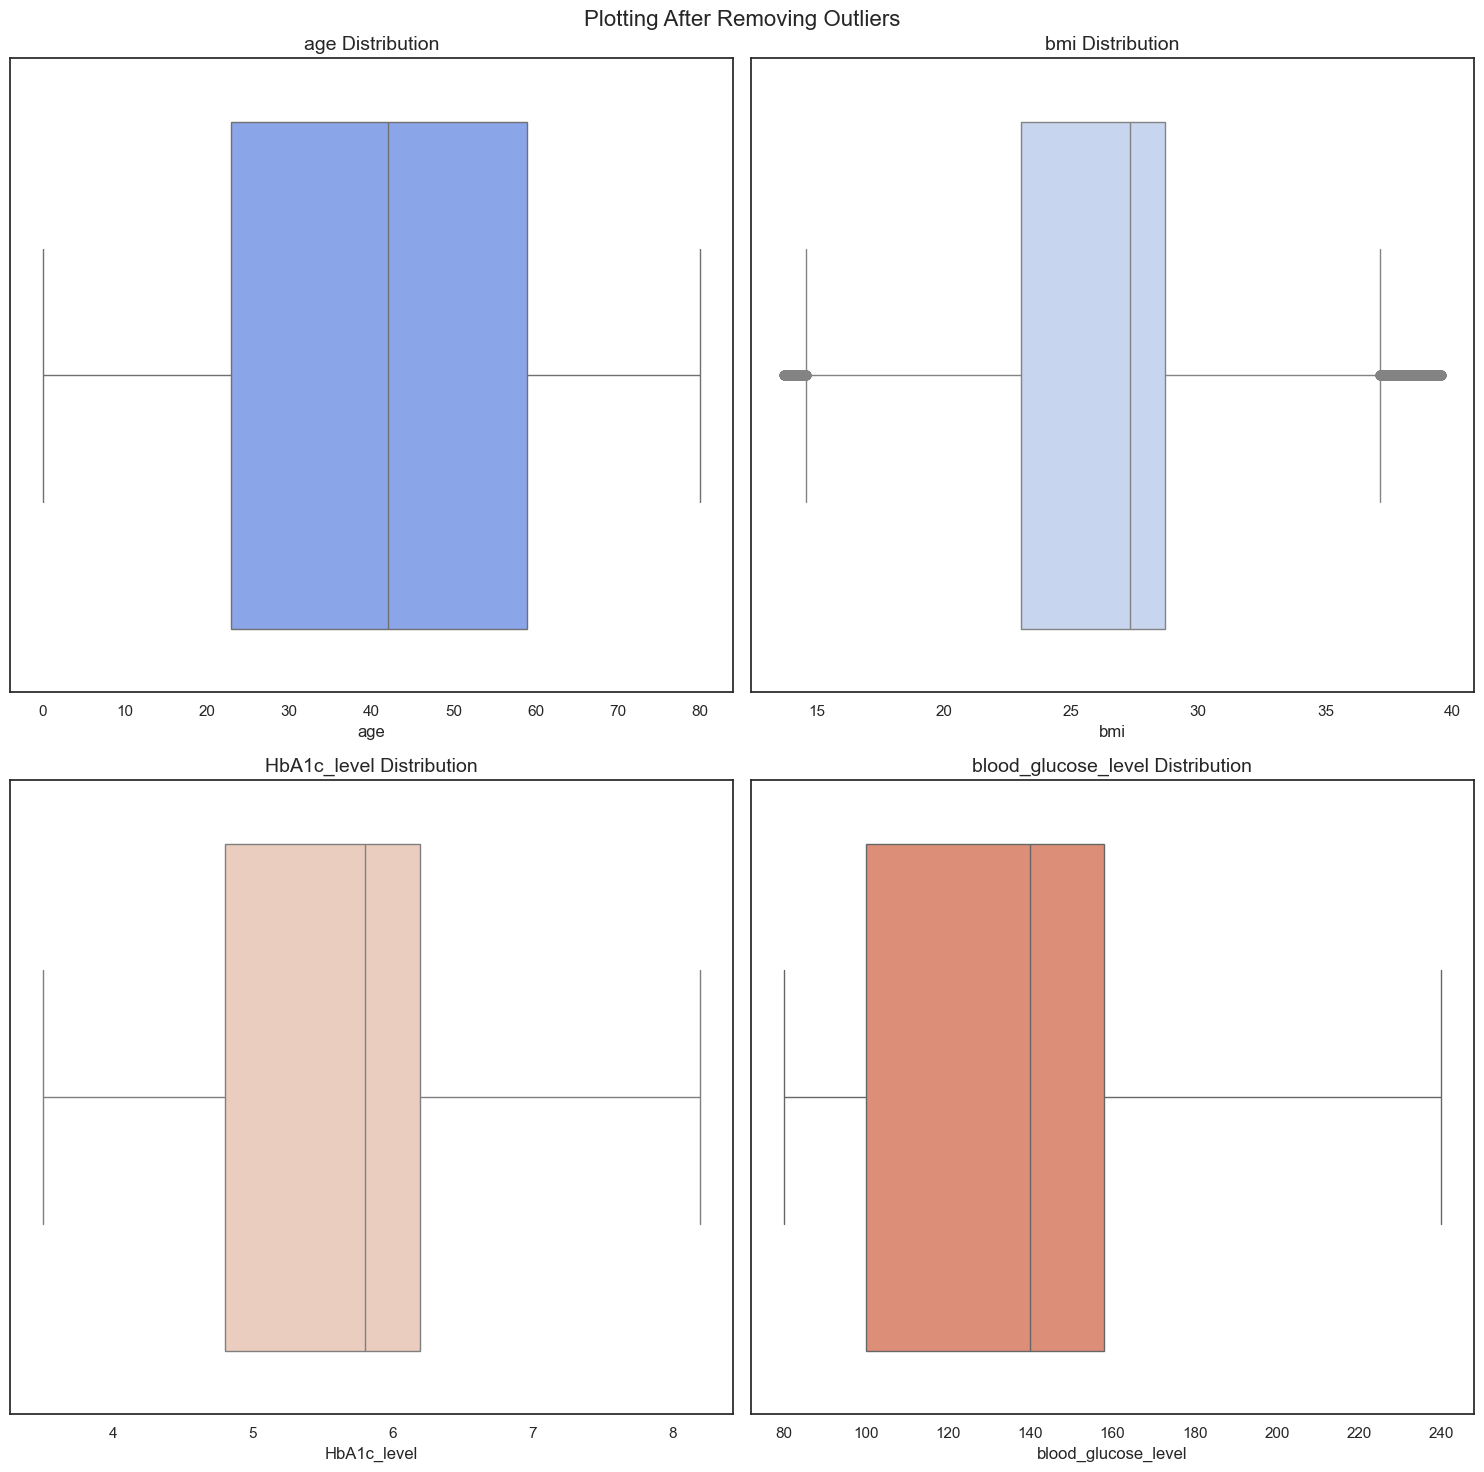

In [128]:
colors = sns.color_palette("coolwarm", n_colors=len(numeric_cols))  
plt.figure(figsize=(15, 15))
for count, col in enumerate(numeric_cols):
    plt.subplot(2, 2, count+1)
    sns.boxplot(data=df_cleaned, x=col, color=colors[count])  
    plt.title(f'{col} Distribution', fontsize=14)  

plt.suptitle("Plotting After Removing Outliers", fontsize=16)
plt.tight_layout()
plt.show()

In [129]:
df=df_cleaned

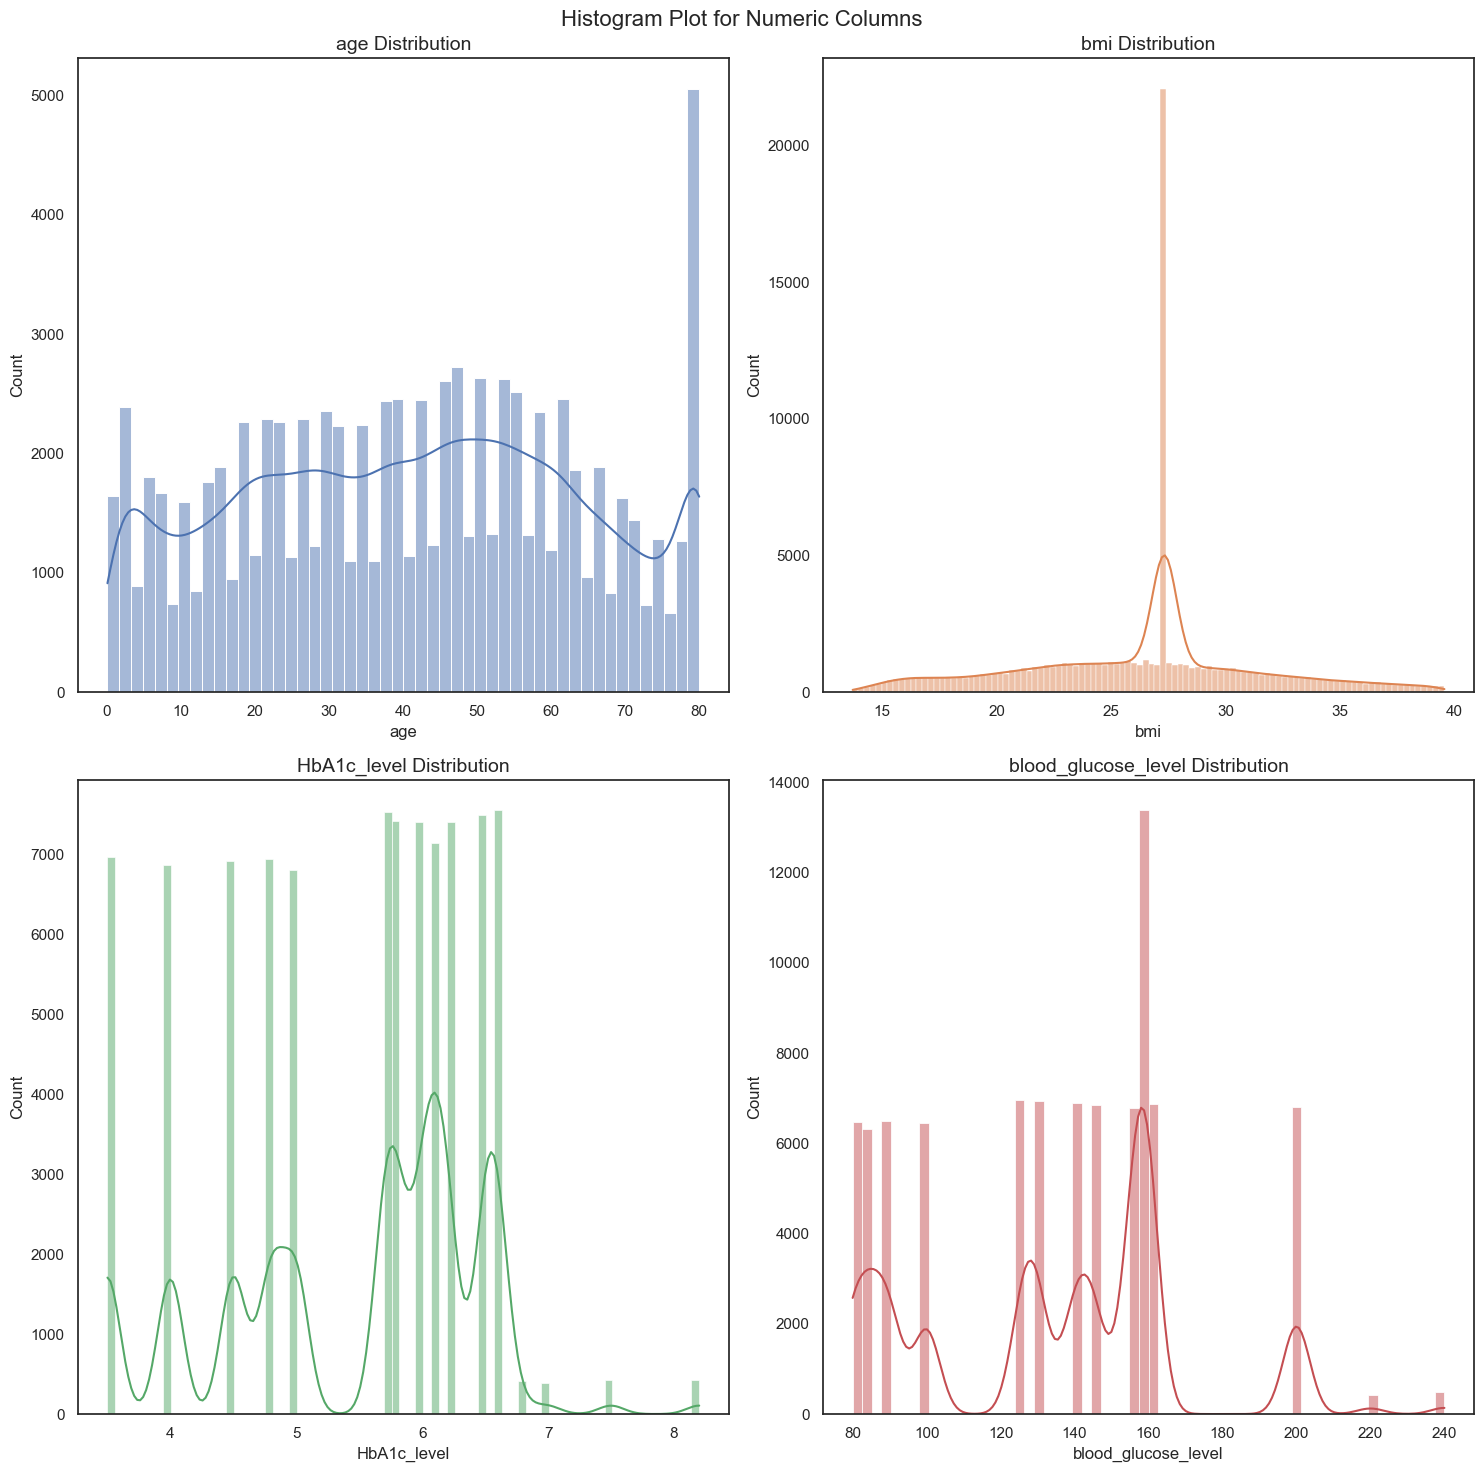

In [130]:
colors = sns.color_palette("deep", n_colors=len(numeric_cols))  
plt.figure(figsize=(15, 15))
for count, col in enumerate(numeric_cols):
    plt.subplot(2, 2, count + 1)
    sns.histplot(data=df, x=col, kde=True, color=colors[count])  
    plt.title(f'{col} Distribution', fontsize=14)  

plt.suptitle("Histogram Plot for Numeric Columns", fontsize=16)
plt.tight_layout()
plt.show()

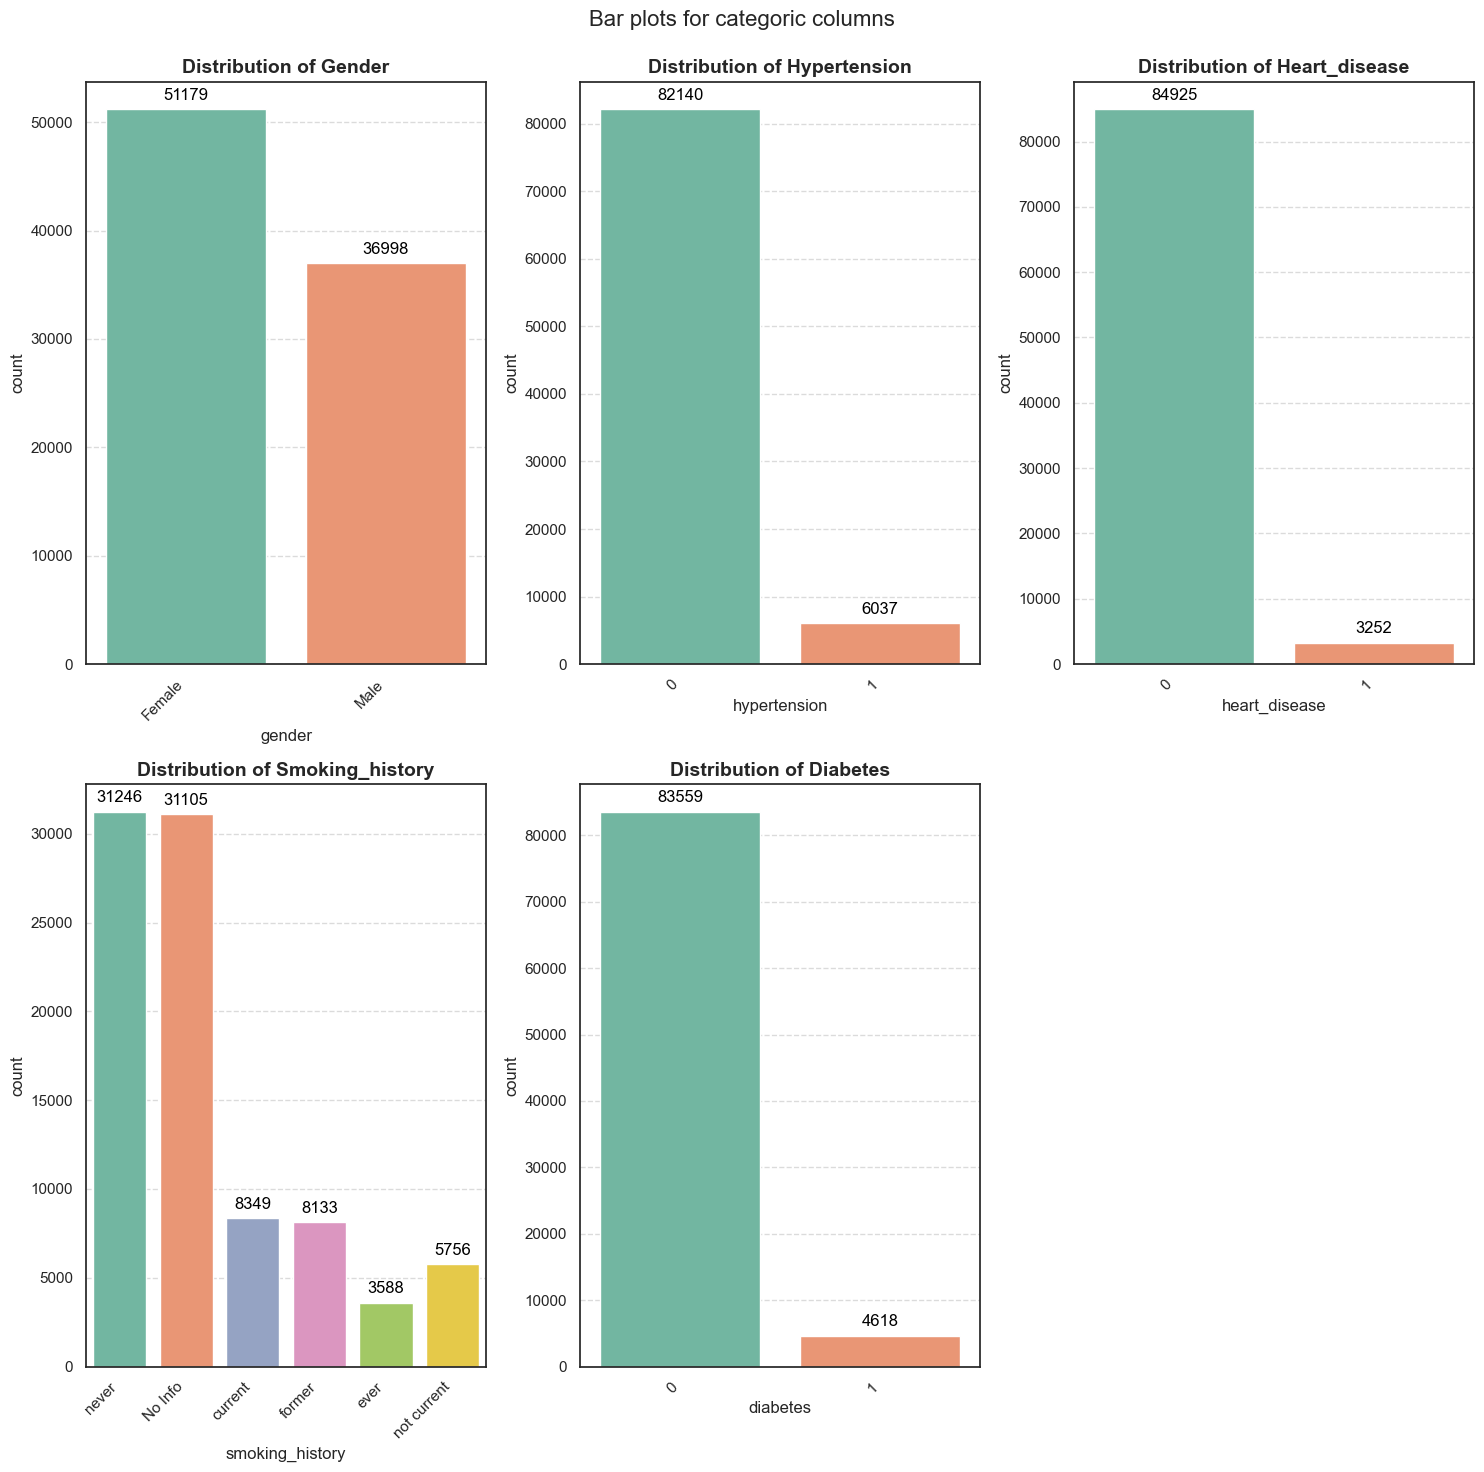

In [131]:
categoric_cols = ['gender', 'hypertension', 'heart_disease', 'smoking_history','diabetes']
plt.figure(figsize=(15, 15))

for count, i in enumerate(categoric_cols):
    plt.subplot(2, 3, count + 1)
    ax = sns.countplot(x=i, data=df, palette="Set2")  
    plt.title(f'Distribution of {i.capitalize()}', fontsize=14, weight='bold')
    plt.xticks(rotation=45, ha='right')  
    plt.grid(axis='y', linestyle='--', alpha=0.7)  

    for p in ax.patches:
        height = int(p.get_height())
        ax.annotate(f'{height}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    fontsize=12, color='black', 
                    xytext=(0, 10),
                    textcoords='offset points')
plt.suptitle('Bar plots for categoric columns\n', fontsize=16)
plt.tight_layout()
plt.show()

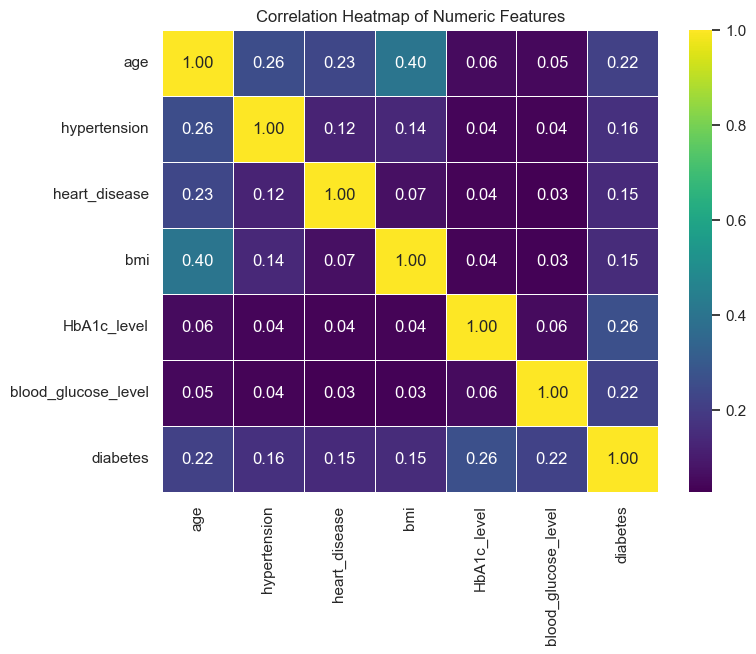

In [132]:
cols=df.select_dtypes(include=np.number)[:-1]
cor_matrix=cols.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(cor_matrix, annot=True, cmap='viridis', fmt=".2f", linewidths=0.5)

plt.title("Correlation Heatmap of Numeric Features")
plt.show()

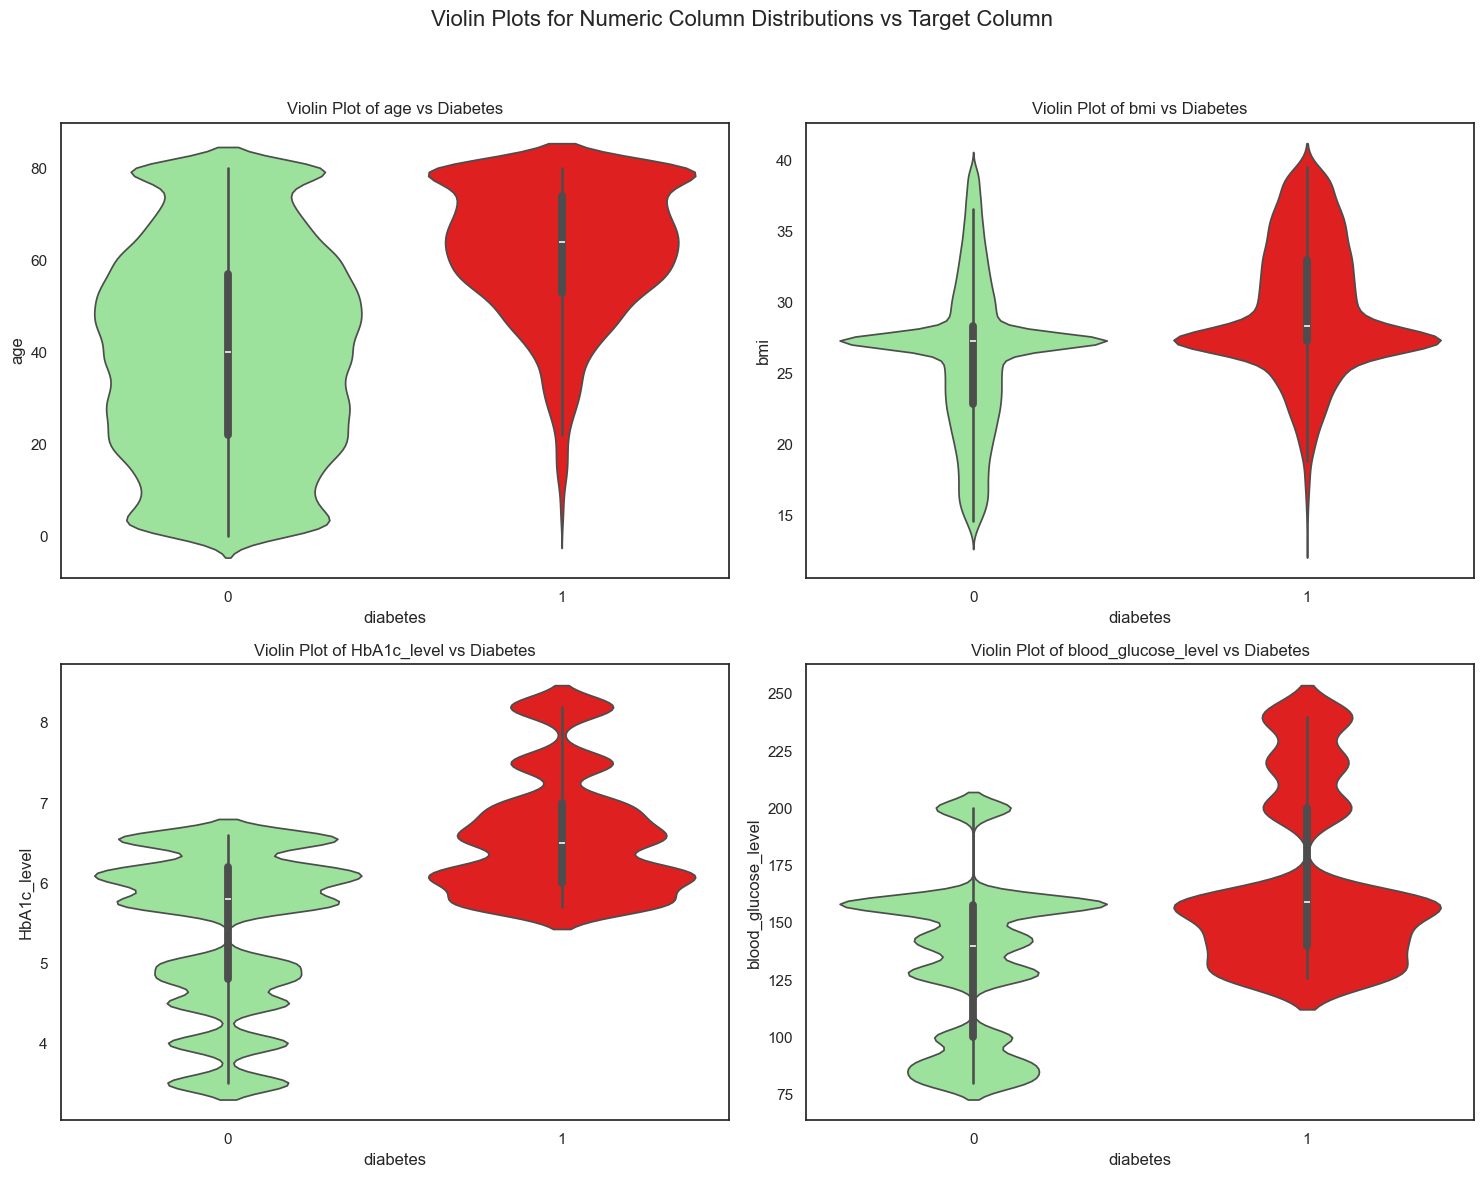

In [133]:
custom_palette = {'0': 'lightgreen', '1': 'red'}

plt.figure(figsize=(15, 12))
for count, col in enumerate(numeric_cols):
    plt.subplot(2, 2, count + 1)  
    sns.violinplot(x='diabetes', y=col, data=df, palette=custom_palette)
    plt.title(f'Violin Plot of {col} vs Diabetes')

plt.suptitle("Violin Plots for Numeric Column Distributions vs Target Column", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


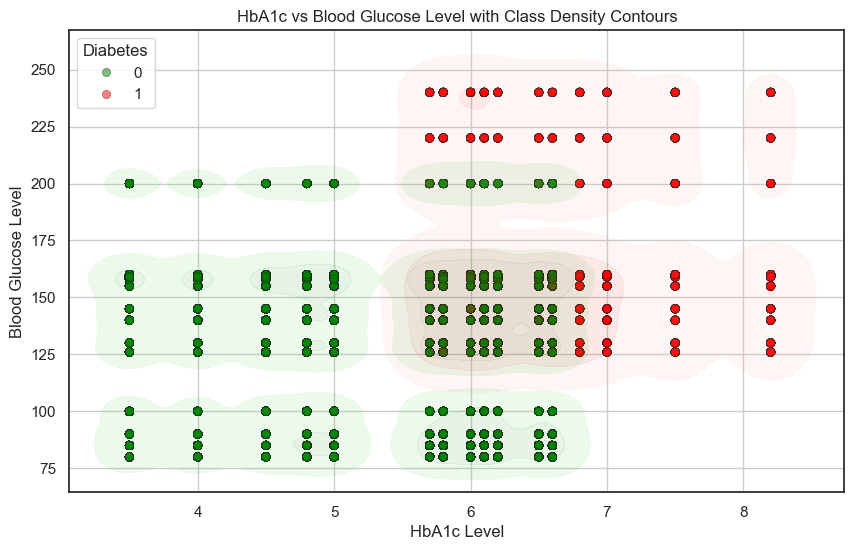

In [134]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x='HbA1c_level',
    y='blood_glucose_level',
    hue='diabetes',
    palette={0: 'green', 1: 'red'},
    alpha=0.5,
    edgecolor='k'
)

for label, color in zip([0, 1], ['green', 'red']):
    subset = df[df['diabetes'] == label]
    sns.kdeplot(
        x=subset['HbA1c_level'],
        y=subset['blood_glucose_level'],
        levels=3,
        color=color,
        linewidths=1.5,
        fill=True,
        alpha=0.1,
        label=f'Density (diabetes={label})'
    )
    
plt.title("HbA1c vs Blood Glucose Level with Class Density Contours")
plt.xlabel("HbA1c Level")
plt.ylabel("Blood Glucose Level")
plt.legend(title="Diabetes")
plt.grid(True)
plt.show()

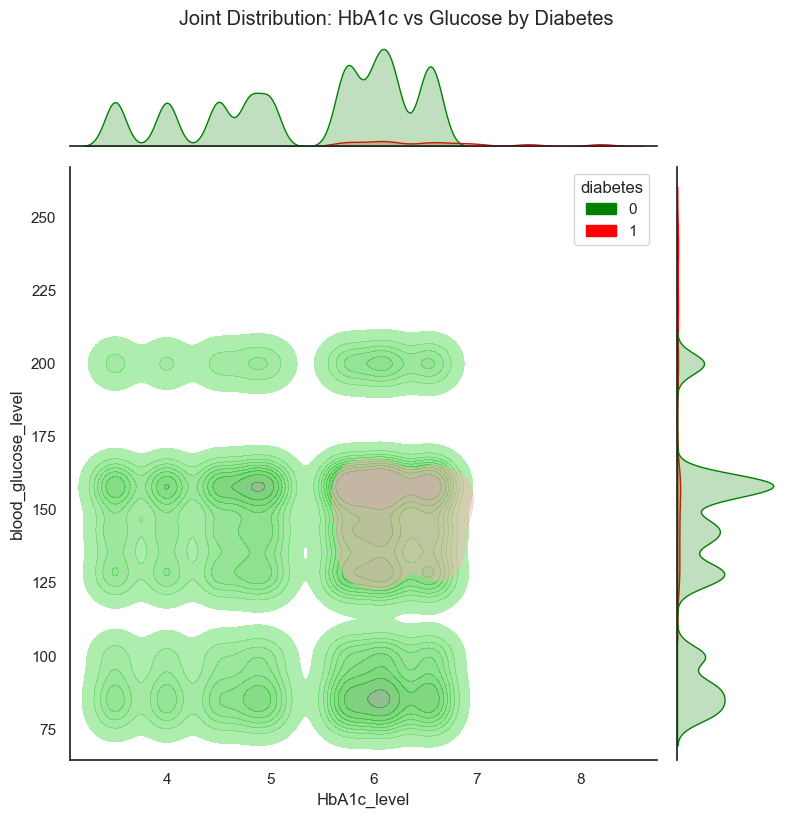

In [135]:
sns.set_theme(style="white")
sns.jointplot(
    data=df,
    x="HbA1c_level",
    y="blood_glucose_level",
    hue="diabetes",
    kind="kde",
    palette={0: "green", 1: "red"},
    fill=True,
    alpha=0.5,
    height=8
)
plt.suptitle("Joint Distribution: HbA1c vs Glucose by Diabetes", y=1.02)
plt.show()

Machine Learning!

In [13]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

In [14]:
X=df.iloc[:,:-1].values
y=df.iloc[:,-1].values

print(pd.DataFrame(X).head(2).to_string(index=False))

     0     1 2 3       4      5    6   7
Female  80.0 0 1   never  25.19  6.6 140
Female  54.0 0 0 No Info  27.32  6.6  80


In [15]:
gender_Encoder=LabelEncoder()
smoking_Encoder=LabelEncoder()

X[:,0]=gender_Encoder.fit_transform(X[:,0])
X[:,4]=smoking_Encoder.fit_transform(X[:,4])

print(pd.DataFrame(X).to_string(index=False))

0     1 2 3 4      5    6   7
0  80.0 0 1 4  25.19  6.6 140
0  54.0 0 0 0  27.32  6.6  80
1  28.0 0 0 4  27.32  5.7 158
0  36.0 0 0 1  23.45  5.0 155
1  76.0 1 1 1  20.14  4.8 155
0  20.0 0 0 4  27.32  6.6  85
0  44.0 0 0 4  19.31  6.5 200
0  79.0 0 0 0  23.86  5.7  85
1  42.0 0 0 4  33.64  4.8 145
0  32.0 0 0 4  27.32  5.0 100
0  53.0 0 0 4  27.32  6.1  85
0  78.0 0 0 3  36.05  5.0 130
0  67.0 0 0 4  25.69  5.8 200
0  76.0 0 0 0  27.32  5.0 160
1  78.0 0 0 0  27.32  6.6 126
1  15.0 0 0 4  30.36  6.1 200
0  42.0 0 0 4  24.48  5.7 158
0  42.0 0 0 0  27.32  5.7  80
1  37.0 0 0 2  25.72  3.5 159
1  40.0 0 0 1  36.38  6.0  90
1   5.0 0 0 0   18.8  6.2  85
0  69.0 0 0 4  21.24  4.8  85
0  72.0 0 1 3  27.94  6.5 130
1  30.0 0 0 4  33.76  6.1 126
1  67.0 0 1 5  27.32  6.5 200
1  40.0 0 0 3  27.85  5.8  80
1  45.0 1 0 4  26.47  4.0 158
1  43.0 0 0 4  26.08  6.1 155
0  53.0 0 0 0  31.75  4.0 200
1  50.0 0 0 0  25.15  4.0 145
0  41.0 0 0 1  22.01  6.2 126
0  20.0 0 0 4  22.19  3.5 100
0  76.0 0 

In [16]:
ct=ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(drop='first'), [0,4])
    ],
    remainder= 'passthrough'
)

X=ct.fit_transform(X)
print(pd.DataFrame(X).head(2).to_string(index=False))

  0    1    2    3    4    5    6     7  8  9      10   11  12
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  80.0  0  1  25.19  6.6 140
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  54.0  0  0  27.32  6.6  80


In [17]:
X_test, X_train, y_test, y_train = train_test_split(
    X, y, test_size=0.25, random_state=2
)

In [18]:
ss_x=StandardScaler()
X_train=ss_x.fit_transform(X_train)
X_test=ss_x.transform(X_test)

TensorFlow!

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.callbacks import EarlyStopping # type: ignore

In [22]:
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

In [23]:
# Define EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),  # First hidden layer
    layers.Dense(32, activation='relu'),  # Second hidden layer
    layers.Dense(16, activation='relu'),  # Third hidden layer
    layers.Dense(1, activation='sigmoid')  # Output layer (Binary classification)
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with EarlyStopping
model.fit(X_train, y_train, 
          epochs=50, 
          batch_size=32, 
          validation_data=(X_test, y_test), 
          callbacks=[early_stop])

Epoch 1/50
707/707 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9137 - loss: 0.2463 - val_accuracy: 0.9609 - val_loss: 0.1123
Epoch 2/50
707/707 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9638 - loss: 0.1062 - val_accuracy: 0.9615 - val_loss: 0.1098
Epoch 3/50
707/707 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9624 - loss: 0.1072 - val_accuracy: 0.9613 - val_loss: 0.1128
Epoch 4/50
707/707 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9668 - loss: 0.1024 - val_accuracy: 0.9633 - val_loss: 0.1052
Epoch 5/50
707/707 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9668 - loss: 0.0976 - val_accuracy: 0.9649 - val_loss: 0.1013
Epoch 6/50
707/707 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9692 - loss: 0.0930 - val_accuracy: 0.9664 - val_loss: 0.0984
Epoch 7/50
707/707 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9694 - loss: 0.0893 - val_accuracy: 0.9685 - val_loss: 0.0945
Epoch 8/50
707/707 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9734 - loss: 0.0847 - val_accuracy: 0.

In [25]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

2119/2119 ━━━━━━━━━━━━━━━━━━━━ 1s 560us/step - accuracy: 0.9722 - loss: 0.0860
Test Accuracy: 0.9720


In [26]:
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype("int")  # Convert probabilities to 0/1
y_test = np.array(y_test.numpy(), dtype=int)


2119/2119 ━━━━━━━━━━━━━━━━━━━━ 1s 442us/step


In [32]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_classes))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99     64354
           1       0.96      0.47      0.63      3436

    accuracy                           0.97     67790
   macro avg       0.96      0.73      0.81     67790
weighted avg       0.97      0.97      0.97     67790



In [27]:
resDF=pd.DataFrame({
    "Predicted Value": y_pred_classes.flatten(),
    "Actual Values": y_test
})

print(resDF.to_string(index=False))


 Predicted Value  Actual Values
               0              0
               0              0
               0              1
               0              0
               0              0
               0              0
               0              0
               0              0
               0              0
               0              0
               0              0
               0              0
               0              0
               0              0
               0              0
               0              0
               0              0
               0              0
               0              0
               0              0
               0              0
               0              0
               0              0
               0              0
               0              0
               0              0
               0              0
               0              0
               0              0
               0              0
        

In [28]:
from sklearn import metrics

print("Accuracy Score", metrics.accuracy_score( y_pred_classes.flatten(), y_test))
print("RMSE", metrics.root_mean_squared_error( y_pred_classes.flatten(), y_test))
print("MAE", metrics.mean_absolute_error( y_pred_classes.flatten(), y_test))

Accuracy Score 0.9720460244873875
RMSE 0.16719442428685377
MAE 0.02795397551261248


In [29]:
print("Mapping of categories to numbers:")
for index, category in enumerate(smoking_Encoder.classes_):
    print(f"{category}: {index}")

Mapping of categories to numbers:
No Info: 0
current: 1
ever: 2
former: 3
never: 4
not current: 5


In [30]:
def get_input():
    
    while True:
        print("\nSelect the patient's gender:")
        print("1: Female")
        print("2: Male")
        gender_choice = input("Enter either 1 or 2: ")
        if gender_choice == '1':
            gender = 'Female'
            break
        elif gender_choice == '2':
            gender = 'Male'
            break
        else:
            print("Invalid input. Please enter 1 for Female or 2 for Male.")
    
    age = int(input("Enter the patient's age: "))
    
    while True:
        print("\nDoes the patient have hypertension?")
        print("1: Yes")
        print("2: No")
        hyper_choice = input("Enter 1 for Yes or 2 for No: ")
        if hyper_choice == '1':
            hyper = 'yes'
            break
        elif hyper_choice == '2':
            hyper = 'no'
            break
        else:
            print("Invalid input. Please enter 1 for Yes or 2 for No.")
            
    while True:
        print("\nDoes the patient have heart disease?")
        print("1: Yes")
        print("2: No")
        heart_choice = input("Enter 1 for Yes or 2 for No: ")
        if heart_choice == '1':
            heart = 'yes'
            break
        elif heart_choice == '2':
            heart = 'no'
            break
        else:
            print("Invalid input. Please enter 1 for Yes or 2 for No.")
    
    while True:
        print("\nSelect the patient's smoking history/status:")
        print("1: Yes")
        print("2: No")
        smokeing = input("Enter 1 for Yes or 2 for No: ")
        break
    

    
    # infinite loops breaks only if valid inputs are received
    bmi = float(input("Enter BMI: "))
    hb_level=float(input("Enter the HbA1c level:"))
    glucose=float(input("Enter the blood glucose level:"))

    return np.array([[gender,age,  hyper, heart, smokeing, bmi, hb_level, glucose ]], dtype=object)